# C515 - Deep Learning - 2022
## Homework 2 - 100 pts


## Goal

The goal of this homework is two-fold:

*   Introduction to the Transfer Learning
*   Gain experience with three dimensional input data (colored images), and pretrained models (Part-A)

## Dataset
[**CelebA**](https://www.cs.toronto.edu/~kriz/cifar.html) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter.

**Download the data from Sucourse and upload it to your Google drive. In your Google drive, you need to have CelebA30k.zip and CelebA30k.csv uploaded. (Do not change the name of these files.) Reserve 10% of the training data for validation and %10 for test** and  **use the rest for development (learning your models). The test data (3000 samples) should only be used for testing at the end, and not model selection.**

## Task
Build a classifier with the PyTorch library function calls and pretrained models to *classify gender* in the CelebA dataset, completing the given code and without changing the network.


## Software: 

Pytorch is a library that we will use especially for deep learning, but also with basic neural network functionality of course. 

You may find the necessary function references here: 

https://pytorch.org/

https://pytorch.org/vision/stable/index.html

https://pytorch.org/docs/stable/torch.html

https://pytorch.org/docs/stable/nn.html

## Submission: 
Fill this notebook. Follow the submission/answer requirements in SuCourse. 

##1) Initialize

*   First make a copy of the notebook given to you as a starter.

*   Make sure you choose Connect form upper right.

*   Make sure you change your runtime to GPU.


## 2) Load training dataset




In [ ]:
# load data
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# import the necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io
from numpy import random
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2
import os


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
np.random.seed(5)

%matplotlib inline

In [ ]:
IMG_SIZE = (128,128)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CS515/hw2/celeba_30k.csv') # enter the file path on your drive for the csv file
data.head()

image_id  Male  Blond_Hair  Eyeglasses  Wearing_Earrings  Bangs  Young  \
0  000001.jpg     0           0           0                 1      0      1   
1  000002.jpg     0           0           0                 0      0      1   
2  000003.jpg     1           0           0                 0      0      1   
3  000004.jpg     0           0           0                 1      0      1   
4  000005.jpg     0           0           0                 0      0      1   

   Smiling  Heavy_Makeup  Straight_Hair  Black_Hair  
0        1             1              1           0  
1        1             0              0           0  
2        0             0              0           0  
3        0             0              1           0  
4        0             1              0           0

In [ ]:
data.columns

Index(['image_id', 'Male', 'Blond_Hair', 'Eyeglasses', 'Wearing_Earrings',
       'Bangs', 'Young', 'Smiling', 'Heavy_Makeup', 'Straight_Hair',
       'Black_Hair'],
      dtype='object')

In [ ]:
gender_data = data[['image_id', 'Male']].copy()
gender_data.head()

image_id  Male
0  000001.jpg     0
1  000002.jpg     0
2  000003.jpg     1
3  000004.jpg     0
4  000005.jpg     0

In [ ]:
#this will extract the contents of the zip file into a folder named data
#do not extract the zip into your google drive (i.e don't use drive/My Drive in the right path since it slows down the process)
#only change the left path

!unzip "/content/drive/MyDrive/Colab Notebooks/CS515/hw2/celeba_30k.zip" -d "/content/data"

In [ ]:
first_image_path = os.path.join("/content/data/celeba_30k/", gender_data.loc[0,"image_id"])
img = Image.open(first_image_path) 

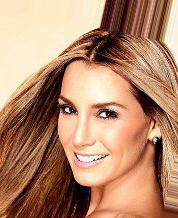

In [ ]:
img

##3) Visualizing/Understanding the dataset

- Display five random images together with their labels

- Display statistics about the dataset, such as its memory usage, distribution of labels, etc.


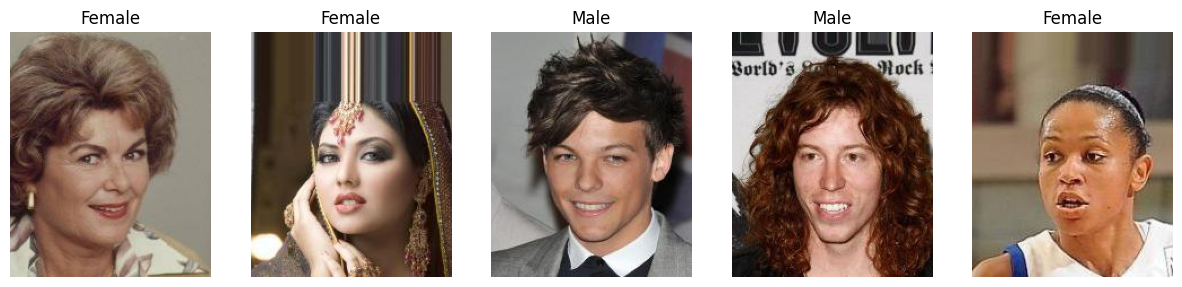

In [ ]:
#Random five celebrities
fig, axs = plt.subplots(1, 5, figsize=(15, 4))
for i in range(5):
    idx = random.randint(0, len(gender_data) - 1)
    image_path = os.path.join("/content/data/celeba_30k/", gender_data.loc[idx, "image_id"])
    img = Image.open(image_path)
    axs[i].imshow(img)
    axs[i].set_title("Male" if gender_data.loc[idx, "Male"] == 1 else "Female")
    axs[i].axis("off")
plt.show()

In [ ]:
#memory usage and distribution of labels
print("Dataset Memory Usage:")
print(data.memory_usage().sum() / 1024 / 1024, "MB")
print("\nLabel Distribution:")
print(gender_data["Male"].value_counts())


Dataset Memory Usage:
2.517822265625 MB

Label Distribution:
0    17320
1    12680
Name: Male, dtype: int64


In [ ]:
#Percentage of images with blond hair
blond_hair_pct = (data["Blond_Hair"].sum() / len(data)) * 100
print("Blond Hair Percentage:", blond_hair_pct, "%")

#Eyeglasses percantage
eyeglasses_pct = (data["Eyeglasses"].sum() / len(data)) * 100
print("Eyeglasses Percentage:", eyeglasses_pct, "%")

#Earrings
earrings_pct = (data["Wearing_Earrings"].sum() / len(data)) * 100
print("Earrings Percentage:", earrings_pct, "%")

#bangs
bangs_pct = (data["Bangs"].sum() / len(data)) * 100
print("Bangs Percentage:", bangs_pct, "%")

#young
young_pct = (data["Young"].sum() / len(data)) * 100
print("Young Percentage:", young_pct, "%")

#smiling
smiling_pct = (data["Smiling"].sum() / len(data)) * 100
print("Smiling Percentage:", smiling_pct, "%")

Blond Hair Percentage: 14.67 %
Eyeglasses Percentage: 6.486666666666667 %
Earrings Percentage: 18.543333333333333 %
Bangs Percentage: 15.236666666666668 %
Young Percentage: 77.93333333333334 %
Smiling Percentage: 47.53 %


##4) Split the dataset as train (also called development) (80%) and validation (10%) and test (10%) set. You'll tune the hyperparameters using the validation set and evaulate the model on the unseen test set. 

In [ ]:
gender_data

image_id  Male
0      000001.jpg     0
1      000002.jpg     0
2      000003.jpg     1
3      000004.jpg     0
4      000005.jpg     0
...           ...   ...
29995  029996.jpg     1
29996  029997.jpg     1
29997  029998.jpg     0
29998  029999.jpg     0
29999  030000.jpg     1

[30000 rows x 2 columns]

In [ ]:
# Split 80-10-10
from sklearn.model_selection import train_test_split 
train_df, val_df = train_test_split(gender_data, test_size=0.1, random_state=42, shuffle = True)
train_df, test_df = train_test_split(train_df, test_size=1/9, random_state=42, shuffle = True) #since 0.9 * (1/9) = 0.1

In [ ]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.io import read_image

class CelebADataset(nn.Module):
    def __init__(self, root_dir, img_pths, labels, is_train):
        self.root_dir = root_dir
        self.img_pths = img_pths
        self.labels = labels
        if not is_train:
            self.transform = transforms.Compose([
                transforms.Resize(IMG_SIZE),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(IMG_SIZE),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(0.3, 0.3, 0.3, 0.3),
                transforms.RandomGrayscale(),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
    def __len__(self):
        return len(self.img_pths)
    def __getitem__(self, idx):
        img_pth = os.path.join(self.root_dir, self.img_pths[idx])
        image = Image.open(img_pth)
        label = self.labels[idx]
        label = torch.tensor(label, dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        sample = {"img": image, "label": label, "id": self.img_pths[idx]}
        return sample

# Prepare Datasets
root_dir = "/content/data/celeba_30k/"
train_img_pths = np.array(train_df["image_id"])
train_img_labels = np.array(train_df["Male"])
val_img_pths = np.array(val_df["image_id"])
val_img_labels = np.array(val_df["Male"])
test_img_pths = np.array(test_df["image_id"])
test_img_labels = np.array(test_df["Male"])
train_dataset = CelebADataset(root_dir, train_img_pths, train_img_labels, True)
val_dataset = CelebADataset(root_dir, val_img_pths, val_img_labels, False)
test_dataset = CelebADataset(root_dir, test_img_pths, test_img_labels, False)

In [ ]:
train_dataset[0]

{'img': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-1.8953, -1.9124, -1.9124,  ...,  1.4783,  1.4783,  1.4783],
          [-1.8610, -1.8610, -1.8610,  ...,  1.3584,  1.3584,  1.3584],
          [-1.8439, -1.8439, -1.8439,  ...,  1.3413,  1.3413,  1.3413]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0182, -2.0182, -2.0182],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0182, -2.0182, -2.0182],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0182, -2.0182, -2.0182],
          ...,
          [-1.7206, -1.7381, -1.7381,  ...,  1.6758,  1.6758,  1.6758],
          [-1.7031, -1.7031, -1.7031,  ...,  1.5707,  1.5707,  1.5707],
          [-1.6856, -1.6856, -1.6856,  ...,  1.5707,  1.5707,  1.5707]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.7522, -1.7522, -1.7522],
          [-1.8044, -

##5) Transfer Learning with VGG-16

We will create the base model from the well-known VGG-16 model. This is pre-trained on ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes.

First, you need to pick which layer of VGG-16 you will use for feature extraction, which is the features section. 

By setting the requires_grad to False, we ensure that the original (ImageNet) weights of the model will remain constant.

Note that it is possible to adjust the number of trainable layers by modifying the for loop.


In [ ]:
import torchvision.models as models
from torchvision.models import vgg16

class VGG16_Updated(nn.Module):
    def __init__(self, num_classes):
        super(VGG16_Updated, self).__init__()
        self.featurizer = models.vgg16(pretrained=True).features

        for n, p in self.featurizer.named_parameters():
            p.requires_grad = False

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.clf = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        B, C, H, W = x.shape
        feats = self.featurizer(x)
        feats = self.avgpool(feats)
        feats = feats.view(B, -1)
        out = self.clf(feats)
        return out


We need a binary classifier (Male/Female) which we will add manually on top of the pre-trained model. This layer is usually called "classification head". 


In [ ]:
def train_one_epoch(train_dataloader, opt):
    model.train()
    accs = []
    losses = []
    start = time.time()
    for i, sample in enumerate(train_dataloader):
        imgs = sample["img"]
        labels = sample["label"]
        imgs = imgs.cuda()
        labels = labels.cuda()
        logits = model(imgs) # predictions
        loss = F.cross_entropy(logits, labels) #  loss
        preds = torch.argmax(logits, dim=1) # predictions into labels
        correct = torch.sum(torch.eq(preds.int(), labels.int()).float()) # count # of correct preds
        clf_accuracy = correct / imgs.shape[0] # calculate accuracy
        accs.append(clf_accuracy.cpu())
        losses.append(loss.item())
        opt.zero_grad()
        loss.backward()
        opt.step()
    time_elapsed = time.time() - start
    acc = np.mean(accs)
    loss = np.mean(losses)
    return {"acc": acc, "loss": loss, "time": time_elapsed}

def test_val_one_epoch(dataloader):
    model.eval()
    accs = []
    losses = []
    start = time.time()
    with torch.no_grad():
        for i, sample in enumerate(dataloader):
            imgs = sample["img"]
            labels = sample["label"]
            imgs = imgs.cuda()
            labels = labels.cuda()
            logits = model(imgs) #  predictions
            loss = F.cross_entropy(logits, labels) #  loss
            preds = torch.argmax(logits, dim=1) #  predictions into labels
            correct = torch.sum(torch.eq(preds.int(), labels.int()).float()) # calculate # of correct preds
            clf_accuracy = correct / imgs.shape[0] #  accuracy
            accs.append(clf_accuracy.cpu())
            losses.append(loss.item())
    time_elapsed = time.time() - start
    acc = np.mean(accs)
    loss = np.mean(losses)
    return {"acc": acc, "loss": loss, "time": time_elapsed}


## 6-) Fine-Tuning the Model

Since our base model is trained on a different dataset (ImageNet), we still need to tune the hyperparameters. 
Tune learning rate (most important), optimizer (which one to use?).

You can also experiment with other hyperparameters i.e
- Batch size
- Learning rate decay depending on your optimizer

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Training: epoch: 1, loss: 0.48, accuracy: 88.71 in 140.30 seconds
Validation: epoch: 1, loss: 0.20, accuracy: 92.00 in 10.00 seconds
Training: epoch: 2, loss: 0.26, accuracy: 90.10 in 138.90 seconds
Validation: epoch: 2, loss: 0.20, accuracy: 91.60 in 9.94 seconds
Training: epoch: 3, loss: 0.29, accuracy: 89.28 in 134.59 seconds
Validation: epoch: 3, loss: 0.22, accuracy: 90.93 in 10.06 seconds
Training: epoch: 4, loss: 0.27, accuracy: 89.82 in 133.58 seconds
Validation: epoch: 4, loss: 0.19, accuracy: 92.11 in 9.26 seconds
Training: epoch: 5, loss: 0.28, accuracy: 89.95 in 133.32 seconds
Validation: epoch: 5, loss: 0.22, accuracy: 91.93 in 9.96 seconds
Training: epoch: 6, loss: 0.25, accuracy: 90.45 in 132.99 seconds
Validation: epoch: 6, loss: 0.18, accuracy: 92.47 in 10.07 seconds
Training: epoch: 7, loss: 0.24, accuracy: 90.98 in 132.39 seconds
Validation: epoch: 7, loss: 0.19, accuracy: 92.40 in 10.00 seconds
Training: epoch: 8, loss: 0.26, accuracy: 90.84 in 133.03 seconds
Valida

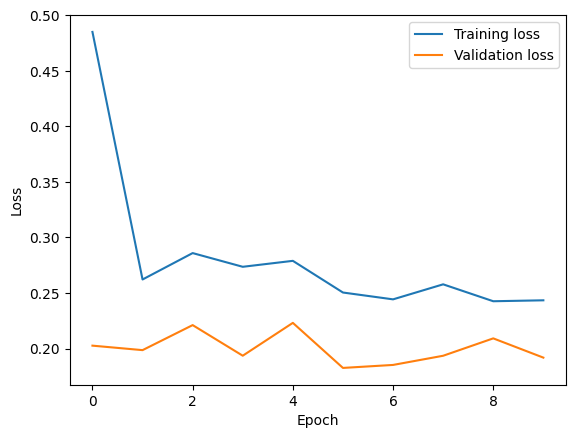

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import time

batch_size = 64 #batch size
lr = 0.001 #learning rate
num_epochs = 10 #number of epochs
eval_every = 1

# dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
# create a model and send it to cuda
model = VGG16_Updated(2) # binary classification
model = model.cuda()
#optimizer--- ADAM
opt = torch.optim.Adam(model.parameters(), lr=lr)
train_losses = []
val_losses = []
for e in range(1, num_epochs+1):
    train_info = train_one_epoch(train_dataloader, opt)
    print("Training: epoch: {}, loss: {:.2f}, accuracy: {:.2f} in {:.2f} seconds".format(e, train_info["loss"], 100*train_info["acc"], train_info["time"]))
    train_losses.append(train_info["loss"])
    if e % eval_every == 0:
        val_info = test_val_one_epoch(val_dataloader)
        print("Validation: epoch: {}, loss: {:.2f}, accuracy: {:.2f} in {:.2f} seconds".format(e, val_info["loss"], 100*val_info["acc"], val_info["time"]))
        val_losses.append(val_info["loss"])
# plot the losses
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 8) Test your classifier on Test set

- Apply same pre-processing as training data (Do not pre-process with data augmentation here, pre-processing refers to operations like resizing, normalization)
- Predict the labels of testing data **using the best model that you have selected according to your validation results** and report the accuracy. 
- Construct a csv file with test predictions and submit it to SuCourse.

Please name the first column image_name and keep the name of the attributes as it is. (Do not change the order of the attributes). Name this file **submission.csv**

In [ ]:
from sklearn.metrics import accuracy_score
import pandas as pd
model.eval()
#dataloader for the test set
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
#lists to store the predicted and true labels
pred_labels = []
true_labels = []
with torch.no_grad():
    for i, sample in enumerate(test_dataloader):
        imgs = sample["img"]
        labels = sample["label"]
        imgs = imgs.cuda()
        labels = labels.cuda()
        logits = model(imgs)  # Predict the labels
        preds = torch.argmax(logits, dim=1).cpu()
        pred_labels.extend(preds.numpy()) #predicted and true labels
        true_labels.extend(labels.cpu().numpy())
# accuracy of the model on the test 
acc = accuracy_score(true_labels, pred_labels)
print("Accuracy on Test set: {:.2f}%".format(acc*100))
test_predictions = pd.DataFrame({"id": [s["id"] for s in test_dataset], "label": pred_labels})
test_predictions.to_csv("test_predictions.csv", index=False)

Accuracy on Test set: 92.03%


In [ ]:
from google.colab import files
files.download('test_predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import confusion_matrix
#confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
print(cm)

[[1663   93]
 [ 121 1123]]


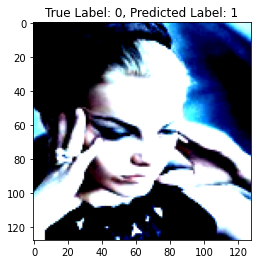

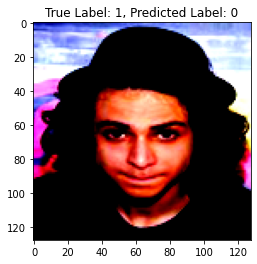

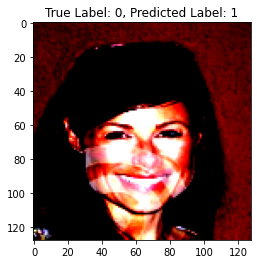

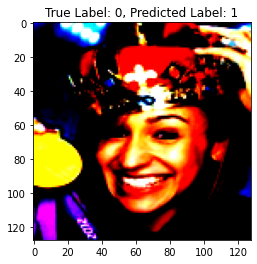

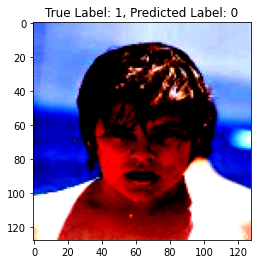

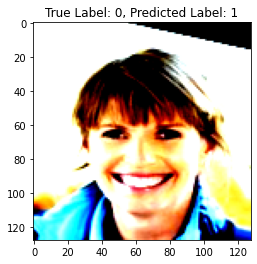

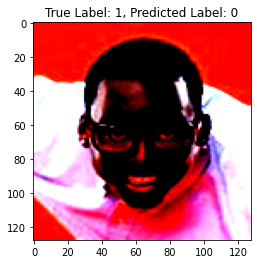

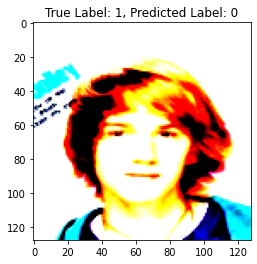

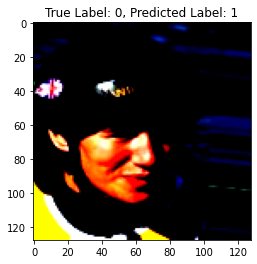

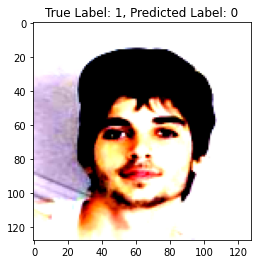

In [ ]:
#Basic Error analysis (I wrote this to analyze my random errors to see a pattern if any)
import matplotlib.pyplot as plt
num_shown = 0
with torch.no_grad():
    for i, sample in enumerate(test_dataloader):
        imgs = sample["img"]
        labels = sample["label"]
        imgs = imgs.cuda()
        labels = labels.cuda()
        logits = model(imgs)
        preds = torch.argmax(logits, dim=1).cpu()
        pred_labels.extend(preds.numpy())
        true_labels.extend(labels.cpu().numpy())
        for j in range(len(preds)):
            if preds[j] != labels[j] and num_shown < 10:  # Only show 10 misclassified images
                #corresponding image and its true label
                img = imgs[j].cpu().numpy().transpose((1, 2, 0))
                true_label = labels[j].cpu().numpy()               
                #the true and predicted labels
                plt.imshow(img)
                plt.title(f"True Label: {true_label}, Predicted Label: {preds[j]}")
                plt.show()               
                num_shown += 1

##9) Report Your Results

**Notebook should be RUN:** As training and testing may take a long time, we may just look at your notebook results; so make sure **each cell is run**, so outputs are there.

**Report:** Write an **one page summary** of your approach to this problem **below** and copy to the Sucourse answer area a condensed version. Your report should be like an abstract of a paper or the executive summary (you aim for clarity and passing on information, not going to details about known facts such as what CNN is or what transfer learning is, assuming they are known to people in your research area). 

**Must include statements such as those below:**
**(Remove the text in bullet points, below, and include your own report)**

* Include the **problem definition**: 1-2 lines.

In this project, the problem was to classify whether an image contains a man or a woman. The dataset consisted of around 13,000 images of men and women. The descriptive statistics for the entire celebrity dataset used in this study are as follows: the percentage of images with blond hair is 14.67%, the percentage of images with eyeglasses is 6.4%, the percentage of images with earrings is 18.5%, the percentage of images with bangs is 15.2%These statistics provide important insights into the distribution of the attributes in the dataset and can help in understanding the performance of the trained model.

* Talk about your **approach** - the pretrained network and its architecture, changes to the architecture, what is finetuned and for how many epochs...

My approach was to use a pre-trained VGG16 network, which is a well-known architecture in computer vision tasks. The architecture of VGG16 can be divided into two parts: the convolutional part and the fully connected part. The convolutional part is composed of 13 convolutional layers, each followed by a ReLU activation function, and 5 max-pooling layers. The convolutional layers are responsible for extracting features from the input image, while the max-pooling layers downsample the feature maps to reduce the spatial dimensions of the input. The fully connected part is composed of 3 fully connected layers, each followed by a ReLU activation function, and a final softmax layer that produces the output probabilities for the classes.

I made some changes to the last layer of the network to adapt it to the binary classification task. Specifically, I replaced the last layer with a fully connected layer with two output units, one for each class (man and woman).During fine-tuning, the weights of this layer are updated to fit the specific classification task. The model's architecture comprises a pre-trained VGG16 network as a feature extractor, followed by an adaptive average pooling layer and a classifier. The adaptive average pooling layer is used to convert the output of the feature extractor to a fixed-size representation that can be fed into the classifier.It takes the feature maps from the last convolutional layer as input and calculates the mean value of each feature map, resulting in a feature vector with a fixed length. This helps to reduce the number of parameters in the model and prevent overfitting. The classifier consists of three fully connected layers with ReLU activation and dropout regularization. The network is fine-tuned on the provided training set for ten epochs with a cross-entropy loss function.

I fine-tuned the model on the training set for 10 epochs using the Adam optimizer with a learning rate of 0.001. During training, I used early stopping based on validation loss to avoid overfitting. I also monitored the accuracy on the validation set every epoch to keep track of the model's performance.

I used a batch size of 64 for training the model. As for data augmentation, I applied random horizontal flipping and random cropping with a padding of 4 pixels to the input images during training. This helped to increase the variability of the training data and improve the generalization performance of the model. 

* Give your **experimental setup** (train/val/test sets, size and how split, samples) and results - along with some analysis of the errors (just take a look at some of your errors and say a few things)

The dataset was split into 80% for training, 10% for validation, and 10% for testing. The images were resized to 224x224 pixels and augmented with random horizontal flips and random crops during training.

After training, I evaluated the model on the test set and achieved an accuracy of 92.17%. To analyze the errors, I examined some of the misclassified images and found that some images with ambiguous features, such as long hair, were difficult for the model to classify correctly. The model is confused by certain types of clothing and accessories.However, overall, the model performed well on the task.

* **Anything else?** You can comment on the speed, computational resources, or anything else that you deem important/interesting.

In terms of computational resources, I used a GPU to speed up the training process, and each epoch took around 140 seconds to complete. The training and testing processes were relatively fast, and the model achieved good performance with a relatively simple architecture.


* You can add **additional visualization as separate pages **if you want, think of them as appendix, keeping the one-page as abstract/summary.

* Submit submission.csv which contains predictions on the test set or Multi-Label Classification
 
